In [ ]:
%%capture
!pip install -q ragas pyngrok dagshub mlflow python-dotenv langchain langchain-openai langchain-together langchain-community langsmith pypdf pinecone pinecone-text streamlit langchain-pinecone langchain-huggingface

In [1]:
#@markdown **You need to sign up for [DagsHub](https://dagshub.com/user/sign_up) , then enter the name of the repository you'd like to create, and your username and email.**

#@markdown Enter the repository name for the project:
REPO_NAME= "komrag-old" #@param {type:"string"}

#@markdown Enter the username of your DAGsHub account:
USER_NAME = "OsipovStas" #@param {type:"string"}

#@markdown Enter the email for your DAGsHub account:
EMAIL = "stasstels@gmail.com" #@param {type:"string"}

#@markdown ---

import IPython

In [3]:
!pwd

/Users/Stanislav_Osipov1/PycharmProjects/komrag-github/notebooks


In [2]:
from dotenv import load_dotenv

load_dotenv("../.env", override=True)

True

In [30]:
import os

DH_TOKEN = os.environ['LLM_MATH_COMP_DH_TOKEN']

In [31]:
import mlflow
import dagshub
import os
#DH_TOKEN = os.environ['LLM_MATH_COMP_DH_TOKEN']
username = f'{USER_NAME}'  # Replace with your DagsHub username
repository = f'{REPO_NAME}'  # Replace with your repository name
token = f'{DH_TOKEN}'  # Replace with your DagsHub token
os.environ['MLFLOW_TRACKING_USERNAME'] = username
os.environ['MLFLOW_TRACKING_PASSWORD'] = token
dagshub.auth.add_app_token(token)
dagshub.init(repo_name=REPO_NAME, repo_owner=USER_NAME)
mlflow.set_tracking_uri(f"https://dagshub.com/{USER_NAME}/{REPO_NAME}.mlflow")
mlflow.set_experiment("komrag_evals")

The added token already exists in the token cache, skipping


Initialized MLflow to track repo "OsipovStas/komrag-old"

Repository OsipovStas/komrag-old initialized!

<Experiment: artifact_location='mlflow-artifacts:/5323b58fc6344b008fdb52c27dc0fbd3', creation_time=1730043880801, experiment_id='1', last_update_time=1730043880801, lifecycle_stage='active', name='komrag_evals', tags={}>

In [ ]:
from dagshub import get_repo_bucket_client
# Get a boto3.client object
s3 = get_repo_bucket_client("OsipovStas/komrag-old")

# Upload file
s3.upload_file(
    Bucket="komrag-old",  # name of the repo
    Filename="./life_begin.pdf",  # local path of file to upload
    Key="life_begin.pdf",  # remote path where to upload the file
)

In [33]:
from dagshub import get_repo_bucket_client
# Get a boto3.client object
s3 = get_repo_bucket_client("OsipovStas/komrag-old")


s3.download_file(
    Bucket="komrag-old",  # name of the repo
    Key="life_begin.pdf",  #  remote path from where to download the file
    Filename="life_begin.pdf",  # local path where to download the file
)

Client created. Use the name of the repo (komrag-old) as the name of the bucket

In [5]:
from dagshub.notebook import save_notebook

save_notebook(repo=f"{USER_NAME}/{REPO_NAME}", path="./notebooks/exploratory-local.ipynb")

Saving only the execution history for the notebook in Jupyter environments

Uploading files (1) to "OsipovStas/komrag"...

Upload finished successfully!

# LLM Configuration

In [3]:
model="gpt-4o-mini-2024-07-18"

In [4]:
model_llama = "meta-llama/Llama-3.2-90B-Vision-Instruct-Turbo"

In [5]:
from langchain_core.rate_limiters import InMemoryRateLimiter

rate_limiter = InMemoryRateLimiter(
    requests_per_second=1,  
    check_every_n_seconds=1,  # Wake up every 1s to check whether allowed to make a request,
    max_bucket_size=2,  
)

/var/folders/sv/znhfybh54fs9s_mgw8bst__m0000gp/T/ipykernel_25118/1513736346.py:3: LangChainBetaWarning: Introduced in 0.2.24. API subject to change.
  rate_limiter = InMemoryRateLimiter(


In [8]:
from langchain_openai import AzureChatOpenAI

chat = AzureChatOpenAI(model=model, temperature=0, timeout=120, rate_limiter=rate_limiter)

In [149]:
from langchain_together import ChatTogether

# choose from our 50+ models here: https://docs.together.ai/docs/inference-models
chat = ChatTogether(
    together_api_key=userdata.get("TOGETHER_KEY"),
    model=model_llama,
    timeout=120,
    rate_limiter=rate_limiter
)

NameError: name 'userdata' is not defined

In [150]:
from langchain_together import ChatTogether

# choose from our 50+ models here: https://docs.together.ai/docs/inference-models
chat = ChatTogether(
    together_api_key=os.environ["TOGETHER_KEY"],
    model=model_llama,
    timeout=120,
    rate_limiter=rate_limiter
)

In [151]:
chat.invoke("Hello, do you know russian? Write a response in it")

AIMessage(content='Здравствуйте! Да, я знаком с русским языком, хотя не могу гарантировать идеальную грамматику и орфографию. Как я могу вам помочь?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 22, 'total_tokens': 65, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta-llama/Llama-3.2-90B-Vision-Instruct-Turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-c797771a-779b-4380-a88d-f45394d24ef4-0', usage_metadata={'input_tokens': 22, 'output_tokens': 43, 'total_tokens': 65, 'input_token_details': {}, 'output_token_details': {}})

In [10]:
from langchain_openai import AzureOpenAIEmbeddings

embeddings = AzureOpenAIEmbeddings(model="text-embedding-3-small-1", dimensions=768)

In [ ]:
from langchain_together import TogetherEmbeddings

embeddings = TogetherEmbeddings(
    together_api_key=userdata.get("TOGETHER_KEY"),
    model="togethercomputer/m2-bert-80M-8k-retrieval",
)



In [11]:
len(embeddings.embed_query("Приветы, как дела?"))

768

# Loading

In [ ]:
file_path = "life_begin.pdf"

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [ ]:
len(pages)

# Text cleanup

In [ ]:
template="""
You will receive a text in Russian extracted using an OCR tool.
Your task is to clean and format this text to enhance readability.
The text may contain various artifacts introduced during the OCR process, such as:

 - Special characters or symbols that do not belong.
 - Inconsistent casing of letters (e.g., random uppercase or lowercase letters).
 - Incorrect spacing within words or between words (e.g., words glued together or unnecessary spaces).
 - Hyphenation errors, such as words split across lines.
 - Incorrect punctuation or misplaced commas and periods.
 - New line characters

Please ensure the final output is free from these artifacts and is well-formatted.
Pay attention to punctuation, paragraph structure, and overall coherence.
The goal is to produce a clean, easy-to-read text.
Output ONLY the cleaned text.


### TEXT ###

{text}

"""

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template(template)

In [ ]:
chain = prompt | chat | StrOutputParser()

In [ ]:
print(chain.invoke({"text": pages[30].page_content}))

In [ ]:
def clean_text(text):
    # try up to 3 times if no success return text as is
    for _ in range(3):
        try:
            return (chain.invoke({"text": text}), True)
        except Exception as e:
            print(f"Error cleaning text: {e}")
    return (text, False)

In [ ]:
from tqdm import tqdm

failures = []
for p in tqdm(pages, desc="Cleaning text", unit="page"):
  text, suc = clean_text(p.page_content)
  if not suc:
    failures.append(p)
  else:
    p.page_content = text

In [ ]:
print(pages[3].page_content)

# Splitting

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
splits = text_splitter.split_documents(pages)

len(splits)

In [ ]:
splits[8]

# Indexing

In [14]:
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key=os.environ['PINECONE_API_KEY'])

In [15]:
pc.list_indexes()

[
    {
        "name": "komrag-hybrid",
        "dimension": 768,
        "metric": "dotproduct",
        "host": "komrag-hybrid-mcvbmc1.svc.aped-4627-b74a.pinecone.io",
        "spec": {
            "serverless": {
                "cloud": "aws",
                "region": "us-east-1"
            }
        },
        "status": {
            "ready": true,
            "state": "Ready"
        },
        "deletion_protection": "disabled"
    },
    {
        "name": "komrag",
        "dimension": 768,
        "metric": "cosine",
        "host": "komrag-mcvbmc1.svc.aped-4627-b74a.pinecone.io",
        "spec": {
            "serverless": {
                "cloud": "aws",
                "region": "us-east-1"
            }
        },
        "status": {
            "ready": true,
            "state": "Ready"
        },
        "deletion_protection": "disabled"
    }
]

In [16]:
import time

index_name = "komrag"  # change if desired

existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

if index_name not in existing_indexes:
    pc.create_index(
        name=index_name,
        dimension=768,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
    while not pc.describe_index(index_name).status["ready"]:
        time.sleep(1)

index = pc.Index(index_name)

In [ ]:
pc.list_indexes()

In [ ]:
from langchain_pinecone import PineconeVectorStore

vectorstore = PineconeVectorStore(index=index, embedding=embeddings)

In [ ]:
import hashlib

def generate_id(content):
    # Ensure the content is in bytes
    if isinstance(content, str):
        content = content.encode('utf-8')

    # Create a SHA-256 hash object
    hash_object = hashlib.sha256()

    # Update the hash object with the content
    hash_object.update(content)

    # Get the hexadecimal representation of the hash
    unique_id = hash_object.hexdigest()

    return unique_id

In [ ]:
def index_all_docs(docs):
  # process docs by batches of 100 docs using tqdm
  for i in tqdm(range(0, len(docs), 100), desc="Indexing", unit="batch"):
    index_batch(docs[i:i+100])

def index_batch(docs):
  ids = [generate_id(doc.page_content) for doc in docs]
  vectorstore.add_documents(documents=docs, ids=ids)

In [ ]:
index_all_docs(pages)

# Hybrid

In [ ]:
import nltk
nltk.download('punkt_tab')

In [17]:
import time

index_name_hybrid = "komrag-hybrid"  # change if desired

existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

if index_name_hybrid not in existing_indexes:
    pc.create_index(
        name=index_name_hybrid,
        dimension=768,
        metric = "dotproduct",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
    while not pc.describe_index(index_name_hybrid).status["ready"]:
        time.sleep(1)

index_hybrid = pc.Index(index_name_hybrid)

In [ ]:
ids = list(index.list())

In [ ]:
r = index.fetch(ids[0])

In [ ]:
r["vectors"]

In [ ]:
from tqdm.auto import tqdm

vectors = []

for page in tqdm(ids):
    # find end of batch
    for k, doc in index.fetch(page)["vectors"].items():
        vectors.append(doc)

In [2]:
from pinecone_text.sparse import BM25Encoder

# or from pinecone_text.sparse import SpladeEncoder if you wish to work with SPLADE

# use default tf-idf values
bm25_encoder = BM25Encoder(language='russian').default()

100% [........................................................................] 65406227 / 65406227

In [4]:
bm25_encoder.dump("bm25_encoder.dump")

In [ ]:
def create_bm25_vec(doc):
    return bm25_encoder._encode_single_document(doc["metadata"]["text"])

In [ ]:
sv = bm25_encoder._encode_single_document(vectors[3]["metadata"]["text"])

In [ ]:
sv = create_bm25_vec(vectors[3])

In [ ]:
sv

In [ ]:
len(vectors)

In [ ]:
index_hybrid.upsert

In [ ]:
for v in tqdm(vectors):
    v["sparse_values"] = create_bm25_vec(v)
    v["metadata"]["context"] = v["metadata"]["text"]

In [ ]:
batch_size = 16

for i in tqdm(range(0, len(vectors), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(vectors))
    # extract batch
    batch = vectors[i:i_end]

    # upload the documents to the new hybrid index
    index_hybrid.upsert(batch)

# show index description after uploading the documents
index_hybrid.describe_index_stats()

In [ ]:
r = index_hybrid.fetch(list(index_hybrid.list())[3])[

In [ ]:
r["vectors"]['695d2fe413863a9953d8edb8f880225dc5136c01d835d9dd2119c6bbf8eff527']

# Retrieve

In [18]:
from langchain_pinecone import PineconeVectorStore

vectorstore = PineconeVectorStore(index=index, embedding=embeddings)

In [19]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})

retrieved_docs = retriever.invoke("В какой температуре купать ребенка?")

len(retrieved_docs)

6

In [ ]:
print(retrieved_docs[0].page_content)

In [ ]:
vectorstore.similarity_search(query="?", filter={"page": 55})

In [22]:
from langchain_community.retrievers.pinecone_hybrid_search import PineconeHybridSearchRetriever

retriever_hybrid = PineconeHybridSearchRetriever(
    embeddings=embeddings, sparse_encoder=bm25_encoder, index=index_hybrid, alpha=0.5
)

In [23]:
retriever_hybrid.invoke("В какой температуре купать ребенка?")

[Document(metadata={'page': 146.0, 'source': 'life_begin_copy.pdf', 'start_index': 605.0, 'text': 'Только так и не иначе, потому что нельзя, ни в коем случае нельзя забывать о том, что перегрев ребенка не менее, а, как правило, значительно более опасен, чем переохлаждение!\n\nПриродные условия обычно позволяют создать оптимальный температурный режим (18–19 °С), но бывают исключения, и они совсем нередки. Ребенок может родиться в жаркое время года, в стране с жарким климатом, в городе, где работники теплосетей склонны с повышенным рвением относиться к своим обязанностям, и т. д.\n\nУберечь ребенка от перегрева при высокой температуре в помещении (выше 22 °С) можно, действуя в четырех направлениях:\n\n1. Одежда, точнее ее минимальное количество.  \n2. Достаточное поступление в организм ребенка жидкости, помимо молока (вода).  \n3. Водные процедуры (душ, ванна).  \n4. Кондиционирование воздуха.  \n\nВоплощать это правило в жизнь необходимо, разумеется, не в пять лет и не в десять, а с мом

# Retrieval

In [24]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "filler context", "question": "filler question"}
).to_messages()

example_messages

[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: filler question \nContext: filler context \nAnswer:", additional_kwargs={}, response_metadata={})]

In [25]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | chat
    | StrOutputParser()
)


In [26]:
from langchain_core.runnables import RunnableMap

# Define a function to capture the retrieved documents
def capture_context(docs):
    return docs['context']

# Modify the chain
rag_chain_map = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | RunnableMap({
        "context": capture_context,
        "response": prompt | chat | StrOutputParser()
    })
)

In [40]:
from langsmith import traceable
from langsmith.wrappers import wrap_openai
from langchain_core.runnables import RunnableMap
from langchain_core.runnables import RunnablePassthrough

class RagBot:

    def __init__(self, retriever, chat):
        self._retriever = retriever
        self.chat = chat
        self.chain = (
            {"context": retriever | self.format_docs, "question": RunnablePassthrough()}
            | RunnableMap({
                "context": self.capture_context,
                "response": prompt | chat | StrOutputParser()
            })
        )

    def format_docs(self, docs):
        self.docs = docs
        return "########\n\n\n###########".join(doc.page_content for doc in docs)

    def capture_context(self, docs):
        return docs["context"].split("########\n\n\n###########")


    @traceable()
    def invoke_llm(self, question):
        answer = self.chain.invoke(question)

        # Evaluators will expect "answer" and "contexts"
        return {
            "answer": answer["response"],
            "context": answer["context"],
        }

    @traceable()
    def get_answer(self, question: str):
        return self.invoke_llm(question)

rag_bot = RagBot(retriever, chat)

In [ ]:

for chunk in rag_chain.stream("При какой температуре купать ребенка?"):
    print(chunk, end="", flush=True)

In [ ]:
rag_chain.invoke("При какой температуре купать ребенка?")

In [ ]:
rag_chain_map.invoke("При какой температуре купать ребенка?")

In [41]:
rag_bot.get_answer("При какой температуре купать ребенка?")

{'answer': 'Оптимальная температура для начала купания ребенка составляет 33–34 °С. В дальнейшем, в зависимости от возраста, температура может снижаться до 28–30 °С для двухмесячного малыша. Важно следить за реакцией ребенка и избегать слишком низких температур, чтобы не вызвать отрицательные эмоции.',
 'context': ['Особый вопрос — погодные условия. При нормальной одежде и защите ребенка от ветра здоровый малыш вполне прилично себя чувствует и при отрицательной температуре. Вот правило, удобное для запоминания: на каждый месяц жизни — минус 5 °С, но не ниже 15 °С. Перевожу: в возрасте 1–2 месяцев температура не должна быть ниже минус 5 °С, в 2–3 месяца — ниже минус 10 °С и т. д.\n\nВсе приведенные цифры и сроки очень и очень условны. При адекватной одежде диапазон температур чрезвычайно широк, а время просто не ограничено. \n\nПо большому счету, холод создает заметно меньшее количество проблем с гулянием по сравнению с теплом (помните, мы еще в главе «Беременность» ратовали за то, чтоб

In [28]:
def predict_rag_answer(example: dict):
    """Use this for answer evaluation"""
    response = rag_bot.get_answer(example["question"])
    return {"answer": response["answer"]}

def predict_rag_answer_with_context(example: dict):
    """Use this for evaluation of retrieved documents and hallucinations"""
    response = rag_bot.get_answer(example["question"])
    return response

# NGROK

In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token(os.environ['NGROK_KEY'])


In [ ]:
import os
print(os.environ['NGROK_KEY'])

In [ ]:
# Start ngrok tunnel
public_url = ngrok.connect(addr='localhost:8501')
print(f"Streamlit app is live at {public_url}")

## Evaluation

# Dataset Generation

In [ ]:
from langchain.chains.qa_generation.prompt import CHAT_PROMPT as pr_prompt

In [ ]:
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate

new_prompt = ChatPromptTemplate.from_messages([
    *pr_prompt.messages,
    HumanMessagePromptTemplate.from_template("Please provide question and answer in Russian language")
])

In [ ]:
prompt = new_prompt

In [ ]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables import (
    RunnableLambda,
    RunnableParallel,
    RunnablePassthrough,
)
from langchain_core.runnables.base import RunnableEach
from langchain_openai import ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter

llm = chat
text_splitter = RecursiveCharacterTextSplitter(chunk_overlap=500)
split_text = RunnableLambda(
    lambda x: text_splitter.create_documents([x])
)

chain = RunnableParallel(
    text=RunnablePassthrough(),
    questions=(
        split_text | RunnableEach(bound=prompt | llm | JsonOutputParser())
    )
)

In [ ]:
docs = vectorstore.similarity_search(query="?", filter={"page": 55})

In [ ]:
print(docs[1].page_content)

In [ ]:
print(docs[1].metadata)

In [ ]:
chain.invoke(docs[1].page_content)

In [ ]:
prompt.messages[1]

In [ ]:
def invoke_chain(text):
  return chain.invoke(text)

In [ ]:
# prompt: # choose randomly 50 pages from interval 30 - 330 and invoke chain on it, specify seed for random, collect result into list

import random

# Assuming 'pages' is your list of pages
# and you want to choose 50 pages randomly from interval 30 - 330

random.seed(31)  # Specify the seed for reproducibility
selected_pages = random.sample(range(30, 330), 50)

In [ ]:

def retrieve_docs_with_metadata_filter(vectorstore, query, metadata_filter):
  """Retrieves documents from the vectorstore based on a query and metadata filter.

  Args:
    vectorstore: The PineconeVectorStore object.
    query: The search query.
    metadata_filter: A dictionary specifying the metadata filter.

  Returns:
    A list of documents matching the query and metadata filter.
  """
  docs = vectorstore.similarity_search(query=query, filter=metadata_filter)
  return docs

selected_docs = [docs for p in selected_pages for docs in vectorstore.similarity_search(query="?", filter={"page": p})]

In [ ]:
len(selected_docs)

In [ ]:
from tqdm import tqdm

results = []
for doc in tqdm(selected_docs[:40], desc="Invoking chain", unit="doc"):
  results.append(invoke_chain(doc.page_content))

In [ ]:
# from each item in result create two dictionaries input and output. input should contain question and metadata keys and output should contain answer
inputs = [{"question": r["questions"][0]["question"]} for r in results]
outputs = [{"answer": r["questions"][0]["answer"]} for r in results]
metadata = [{**d.metadata, "id": d.id, "text": d.page_content} for  d in selected_docs]

# Storing to Langsmith

In [29]:
from langsmith import Client

client = Client()
dataset_name = "Life begins questions"

In [ ]:
# Storing inputs in a dataset lets us
# run chains and LLMs over a shared set of examples.
dataset = client.create_dataset(
  dataset_name=dataset_name, description="Questions and answers to life begins book.",
)

In [30]:
dataset = client.read_dataset(dataset_name=dataset_name)

In [ ]:
client.create_examples(
  inputs=inputs,
  outputs=outputs,
  metadata=metadata,
  dataset_id=dataset.id,
)

# Response vs reference answer(correctness)

In [ ]:
from langsmith.schemas import Example, Run


In [ ]:
llm = AzureChatOpenAI(model=model, temperature=0)


In [ ]:
from langchain import hub

# Grade prompt
grade_prompt_answer_accuracy = hub.pull("langchain-ai/rag-answer-vs-reference")

def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """

    # Get question, ground truth answer, RAG chain answer
    input_question = example.inputs["question"]
    reference = example.outputs["answer"]
    prediction = run.outputs["answer"]

    # LLM grader

    # Structured prompt
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke({"question": input_question,
                                  "correct_answer": reference,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_v_reference_score", "score": score}

In [ ]:
ex = [e for e in client.list_examples(dataset_name=dataset_name)][4]

In [ ]:
ex.outputs["question"]

In [ ]:
answer_evaluator({"outputs": predict_rag_answer(ex.inputs)}, ex)

In [ ]:
predict_rag_answer(ex.inputs)

# Response vs input (Answer Relevance)

In [ ]:
grade_prompt_answer_helpfulness = hub.pull("langchain-ai/rag-answer-helpfulness")

def answer_helpfulness_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer helpfulness
    """

    # Get question, ground truth answer, RAG chain answer
    input_question = example.inputs["question"]
    prediction = run.outputs["answer"]

    # LLM grader

    # Structured prompt
    answer_grader = grade_prompt_answer_helpfulness | llm

    # Run evaluator
    score = answer_grader.invoke({"question": input_question,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_helpfulness_score", "score": score}

# Response vs Restrieved Docs(Faithfullnes)

In [ ]:
# Prompt
grade_prompt_hallucinations = hub.pull("langchain-ai/rag-answer-hallucination")

def answer_hallucination_evaluator(run, example) -> dict:
    """
    A simple evaluator for generation hallucination
    """

    # RAG inputs
    input_question = example.inputs["question"]
    contexts = run.outputs["context"]

    # RAG answer
    prediction = run.outputs["answer"]

    # LLM grader

    # Structured prompt
    answer_grader = grade_prompt_hallucinations | llm

    # Get score
    score = answer_grader.invoke({"documents": contexts,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_hallucination", "score": score}

# Retrieved docs vs Input (Ctx. Relevancy)

In [ ]:
# Grade prompt
grade_prompt_doc_relevance = hub.pull("langchain-ai/rag-document-relevance")



def docs_relevance_evaluator(run, example) -> dict:
    """
    A simple evaluator for document relevance
    """

    # RAG inputs
    input_question = example.inputs["question"]
    context = run.outputs["context"]


    # Structured prompt
    answer_grader = grade_prompt_doc_relevance | llm

    # Get score
    score = answer_grader.invoke({"question":input_question,
                                  "documents":context})
    score = score["Score"]

    return {"key": "document_relevance", "score": score}

# Run evaluations

In [ ]:
from langsmith.evaluation import evaluate

experiment_results = evaluate(
    predict_rag_answer_with_context,
    data=client.list_examples(dataset_name=dataset_name),
    evaluators=[answer_evaluator, answer_helpfulness_evaluator, answer_hallucination_evaluator, docs_relevance_evaluator],
    experiment_prefix="komrag-evaluations",
    metadata={"model": "Llama3.2-11B", "retriever": "hybrid"},
)

In [ ]:
rag_bot = RagBot(retriever=retriever_hybrid, chat=chat)

In [ ]:
predict_rag_answer(list(client.list_examples(dataset_name=dataset_name))[3].inputs)

In [ ]:
list(client.list_examples(dataset_name=dataset_name))[3].inputs

In [ ]:
res = list(experiment_results)

# ML FLOW Evaluations

In [11]:
import pandas as pd

In [108]:
from ragas.llms import LangchainLLMWrapper

grader = LangchainLLMWrapper(AzureChatOpenAI(model=model, temperature=0))

In [33]:
def get_examples_from_langsmith():
    data = client.list_examples(dataset_name=dataset_name)
    return data

In [ ]:
def collect_examples(generator):
    inputs = []
    outputs = []
    
    for example in generator:
        inputs.append(example.inputs["question"])
        outputs.append(example.outputs["answer"])
        
    return {"inputs": inputs, "ground_truth": outputs}

In [112]:
from ragas import SingleTurnSample

def collect_samples(generator):
    samples = []   
    for example in tqdm(generator):
        response = predict_rag_answer_with_context(example.inputs)
        sample = SingleTurnSample(
            user_input=example.inputs["question"],
            reference=example.outputs["answer"],
            retrieved_contexts=response["context"],
            response=response["answer"],
        )
        samples.append(sample)    
    return samples

In [ ]:
ds = EvaluationDataset(samples=samples)

In [109]:
from ragas.metrics import ResponseRelevancy, LLMContextRecall, Faithfulness, FactualCorrectness, ContextPrecision, SemanticSimilarity
from ragas import evaluate, EvaluationDataset


metrics = [
    LLMContextRecall(llm=grader), 
    Faithfulness(llm=grader),
    ContextPrecision(llm=grader),
    ResponseRelevancy(llm=grader),
]

In [155]:
import pandas as pd
from tqdm import tqdm

rag_bot = RagBot(chat=chat, retriever=retriever_hybrid)
data = EvaluationDataset(samples=collect_samples(get_examples_from_langsmith()))

48it [02:27,  3.07s/it]


In [156]:
results = evaluate(dataset=data, metrics=metrics)

Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [02:33<00:00,  1.25it/s]


In [157]:
df = results.to_pandas()
dfm = df.mean(numeric_only=True)
dfm = pd.DataFrame(dfm).T
dfm["Retriever AVG"] = dfm[["context_recall", "context_precision"]].mean(axis=1)
dfm["Generator AVG"] = dfm[["faithfulness", "answer_relevancy"]].mean(axis=1)
dfm["Total AVG"] = dfm.mean(axis=1)

with mlflow.start_run() as run:
    mlflow.log_param("model", model_llama)
    mlflow.log_param("index_name", index_name_hybrid)
    mlflow.log_metrics(dfm.iloc[0].to_dict())
    mlflow.log_table(data=df, artifact_file="komrag_test_eval_results.json")

2024/10/28 16:36:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run marvelous-deer-631 at: https://dagshub.com/OsipovStas/komrag.mlflow/#/experiments/1/runs/47ceb6ffefea483ab39b6ea795f4b7cb.
2024/10/28 16:36:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/OsipovStas/komrag.mlflow/#/experiments/1.


In [21]:
experiment_name = "komrag_evals"
experiment = mlflow.get_experiment_by_name(experiment_name)
experiment_id = experiment.experiment_id

<Experiment: artifact_location='mlflow-artifacts:/4aaff30f7bc34c46ab3bd316ab7d8c42', creation_time=1730201784698, experiment_id='1', last_update_time=1730201784698, lifecycle_stage='active', name='komrag_evals', tags={}>

In [22]:
# Retrieve all runs with the tag 'llm_zoomcamp'
runs = mlflow.search_runs(
    experiment_ids=[experiment_id],
    filter_string="tags.llm_zoomcamp != 'None'"
)

In [23]:
# Collect the data for the DataFrame
data = []
for _, row in runs.iterrows():
    run_data = {
        "llm_zoomcamp": row['tags.llm_zoomcamp']
    }
    # Assuming metrics are stored with a 'metrics.' prefix
    metrics = {key.split('.')[1]: value for key, value in row.items() if key.startswith('metrics.')}
    run_data.update(metrics)
    data.append(run_data)

# Create the DataFrame
df = pd.DataFrame(data)

# Set 'llm_zoomcamp' as the index
df.set_index("llm_zoomcamp", inplace=True)

print(df)

                   Generator AVG  answer_relevancy  context_recall  \
llm_zoomcamp                                                         
llama3.2_hybrid         0.929071          0.925404        0.928819   
llama-dense             0.902050          0.868684        0.913194   
gpt4o-mini-hybrid       0.902220          0.875299        0.923611   
gpt4o-mini-dense        0.890344          0.871214        0.913194   

                   context_precision  Retriever AVG  faithfulness  Total AVG  
llm_zoomcamp                                                                  
llama3.2_hybrid             0.886574       0.907697      0.932738   0.918384  
llama-dense                 0.828200       0.870697      0.935417   0.886374  
gpt4o-mini-hybrid           0.880787       0.902199      0.929142   0.902210  
gpt4o-mini-dense            0.818657       0.865926      0.909474   0.878135  


In [18]:
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time


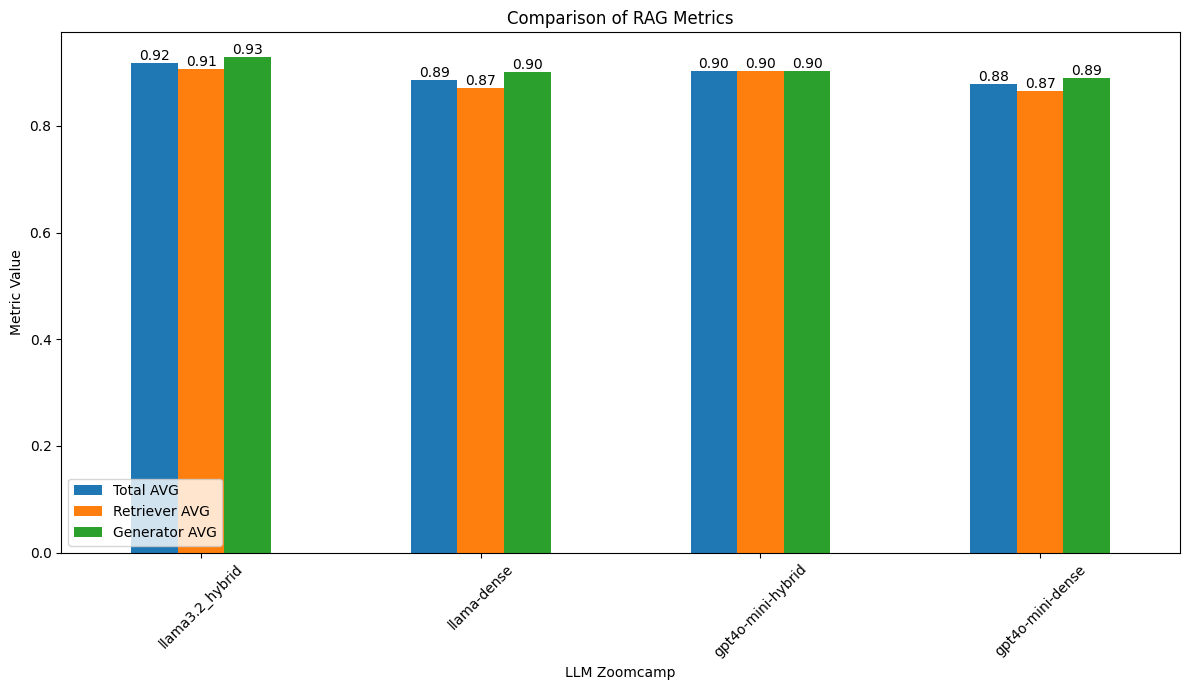

In [195]:
import matplotlib.pyplot as plt

# Filter the DataFrame for AVG metrics
avg_metrics_df = df.filter(like='AVG')

# Plot the bar chart
ax = avg_metrics_df.plot(kind='bar', figsize=(12, 7), legend=True)
plt.title('Comparison of RAG Metrics')
plt.xlabel('LLM Zoomcamp')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)

# Annotate each bar with its value
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')

plt.tight_layout()
plt.show()

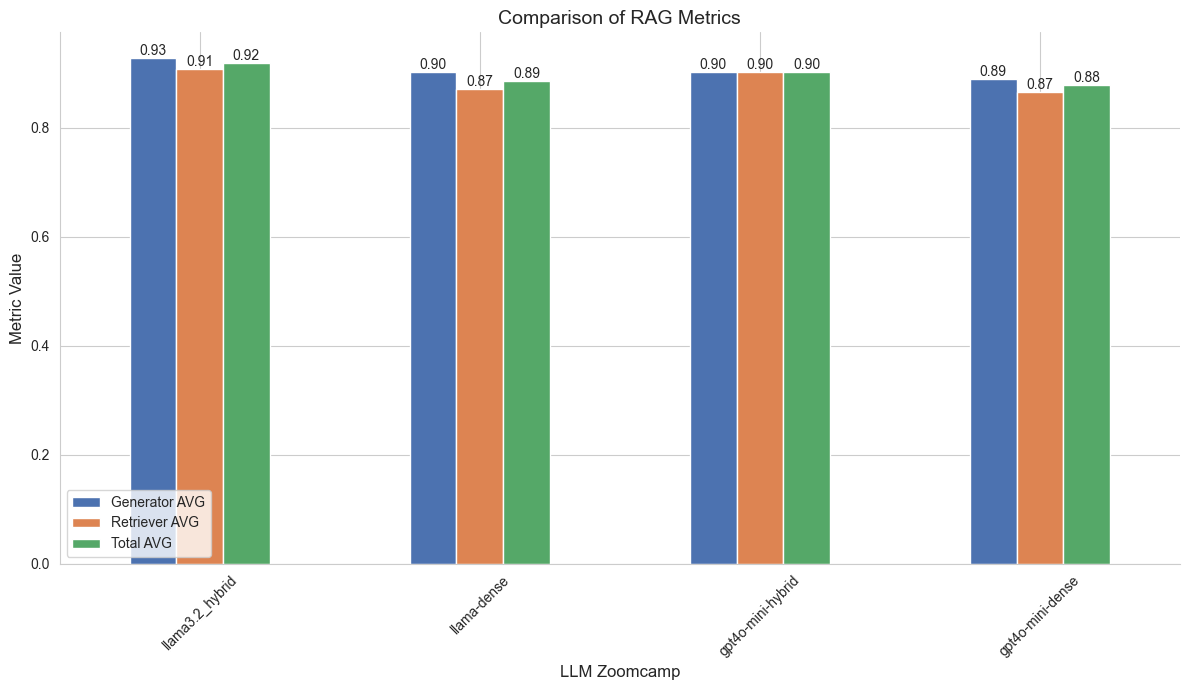

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame for AVG metrics
avg_metrics_df = df.filter(like='AVG')

# Set a color palette using 'deep'
colors = sns.color_palette("deep", len(avg_metrics_df.columns))

# Set the style of the plot
sns.set_style("whitegrid")

# Plot the bar chart with custom colors
ax = avg_metrics_df.plot(kind='bar', figsize=(12, 7), color=colors, legend=True)
plt.title('Comparison of RAG Metrics', fontsize=14)
plt.xlabel('LLM Zoomcamp', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Annotate each bar with its value
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')

# Remove the top and right spines
sns.despine()

plt.tight_layout()
plt.savefig('avg_metrics_comparison.jpg', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>

In [197]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
